In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy.stats import pearsonr, spearmanr, kstest
from statsmodels.stats.power import TTestIndPower

In [2]:
df = pd.read_csv("mental_health_monitoring_dataset.csv")
df.head()

,Timestamp,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Skin_Temperature,Galvanic_Skin_Response,Respiration_Rate,Sleep_Duration,Activity_Levels,Mood,...,Fuel_Consumption,Average_Speed,Work_Hours,Job_Stressors,Location_Latitude,Location_Longitude,Stress_Level,Mental_Health_History,Resilience_Factors,Mental_Health_Status
0,2019-01-01 00:00:00,98,177,99,36.854833,0.603660,20,4,4945,Happy,...,17.568925,78,12,5,51.002436,44.895265,Low,Yes,5,Normal
1,2019-01-01 01:00:00,111,133,86,37.239401,0.934820,24,5,6221,Happy,...,10.295241,25,8,9,42.839887,75.276677,Low,No,2,Moderate Stress
2,2019-01-01 02:00:00,88,154,113,36.209588,0.035483,28,1,6426,Anxious,...,8.515171,37,15,9,68.836583,20.795174,Low,No,4,Depression
3,2019-01-01 03:00:00,74,162,60,36.087569,0.653249,25,4,14435,Happy,...,13.774633,39,15,5,51.752928,89.835756,Low,No,1,Normal
4,2019-01-01 04:00:00,102,160,81,36.593949,0.756138,15,6,4334,Happy,...,18.747632,87,11,1,98.613250,86.654677,Low,No,2,Moderate Stress


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 52585 non-null  object 
 1   Heart_Rate                52585 non-null  int64  
 2   Blood_Pressure_Systolic   52585 non-null  int64  
 3   Blood_Pressure_Diastolic  52585 non-null  int64  
 4   Skin_Temperature          52585 non-null  float64
 5   Galvanic_Skin_Response    52585 non-null  float64
 6   Respiration_Rate          52585 non-null  int64  
 7   Sleep_Duration            52585 non-null  int64  
 8   Activity_Levels           52585 non-null  int64  
 9   Mood                      52585 non-null  object 
 10  Cognitive_Load            52585 non-null  int64  
 11  Social_Interaction        52585 non-null  int64  
 12  Driving_Conditions        52585 non-null  object 
 13  Route_Duration            52585 non-null  int64  
 14  Fuel_C

# Preprocessing Data

In [4]:
# Check for missing values
missing_values = df.isnull().sum()

# Display only columns with missing values
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print("Columns with missing values:\n", missing_values)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [5]:
# Drop features
df.drop(df.columns[[0, 12, 18, 19]], axis=1, inplace=True)

In [6]:
# Convert categorical variables to numerical 
categorical_features = ["Mood", "Mental_Health_History", "Stress_Level", "Mental_Health_Status"]

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categories to numbers
    label_encoders[col] = le  # Store encoders for inverse transformation if needed

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
#numerical_features = [col for col in df.columns if col not in categorical_features] # Exclude categorical
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()  # Select numerical columns
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Apply Min-Max Scaling (scale to range 0-1) 
minmax_scaler = MinMaxScaler()
df[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])

# Display the first few rows of the preprocessed dataset
print(df.head())

   Heart_Rate  Blood_Pressure_Systolic  Blood_Pressure_Diastolic  \
0    0.644068                 0.977528                  0.661017   
1    0.864407                 0.483146                  0.440678   
2    0.474576                 0.719101                  0.898305   
3    0.237288                 0.808989                  0.000000   
4    0.711864                 0.786517                  0.355932   

   Skin_Temperature  Galvanic_Skin_Response  Respiration_Rate  Sleep_Duration  \
0          0.594666                0.603680          0.470588        0.444444   
1          0.692386                0.934856          0.705882        0.555556   
2          0.430706                0.035474          0.941176        0.111111   
3          0.399700                0.653271          0.764706        0.444444   
4          0.528374                0.756165          0.176471        0.666667   

   Activity_Levels  Mood  Cognitive_Load  Social_Interaction  Route_Duration  \
0         0.247225  0.25

In [7]:
# Define feature categories
phys_features = [
    "Heart_Rate", "Blood_Pressure_Systolic", "Blood_Pressure_Diastolic",
    "Skin_Temperature", "Galvanic_Skin_Response", "Respiration_Rate", "Activity_Levels",
    "Sleep_Duration", "Mental_Health_Status"
]

psych_features = [
    "Mood", "Job_Stressors", "Resilience_Factors", 
    "Mental_Health_History", "Mental_Health_Status",
    "Cognitive_Load", "Stress_Level"
]

context_features = [
    "Social_Interaction", "Route_Duration", "Mental_Health_Status",
    "Fuel_Consumption", "Average_Speed", "Work_Hours",
]

# Create separate DataFrames for each category
df_phys = df[phys_features]
df_psych = df[psych_features]
df_context = df[context_features]

# Compute Correlations

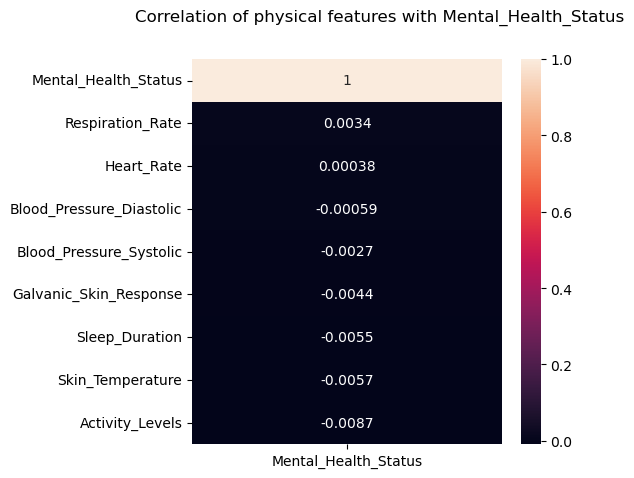

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Correlation of physical features with Mental_Health_Status')
corr = df_phys.corr()[['Mental_Health_Status']].sort_values(by='Mental_Health_Status', ascending=False)
hm = sns.heatmap(corr, annot=True)

-> Out of the physiological features, Activity_Levels has the strongest correlation with Mental_Health_Status.

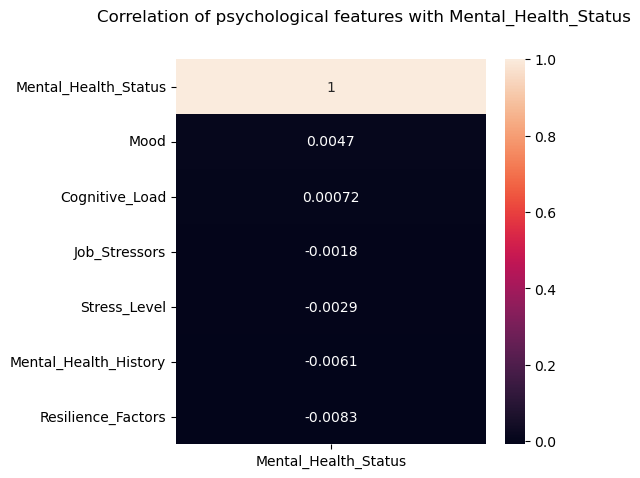

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Correlation of psychological features with Mental_Health_Status')
corr = df_psych.corr()[['Mental_Health_Status']].sort_values(by='Mental_Health_Status', ascending=False)
hm = sns.heatmap(corr, annot=True)

-> Out of the psychological features, Resilience_Factors has the strongest correlation with Mental_Health_Status

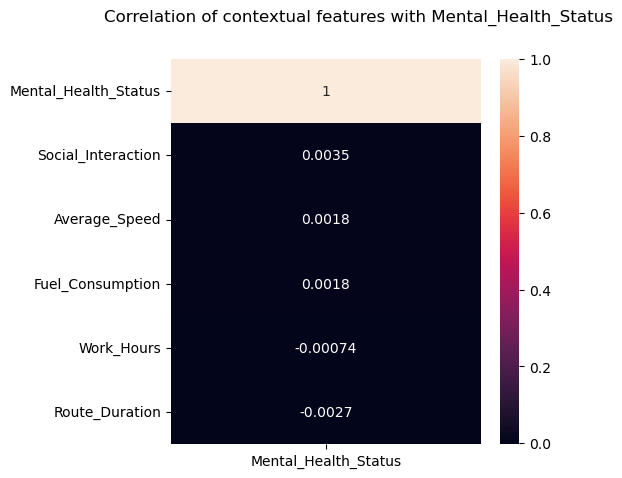

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Correlation of contextual features with Mental_Health_Status')
corr = df_context.corr()[['Mental_Health_Status']].sort_values(by='Mental_Health_Status', ascending=False)
hm = sns.heatmap(corr, annot=True)

-> Out of the contextual features, Social_Interaction has the strongest correlation with Mental_Health_Status

In [11]:
# Compute correlation of each feature_category with Mental Health Status
phys_features = [
    "Heart_Rate", "Blood_Pressure_Systolic", "Blood_Pressure_Diastolic",
    "Skin_Temperature", "Galvanic_Skin_Response", "Respiration_Rate",
    "Sleep_Duration", "Activity_Levels"
]

psych_features = [
    "Mood", "Cognitive_Load", "Job_Stressors", 
    "Stress_Level", "Resilience_Factors", "Mental_Health_History"
]

context_features = [
    "Social_Interaction", "Route_Duration", "Fuel_Consumption", 
    "Average_Speed", "Work_Hours"
]

df_phys = df[phys_features]
df_psych = df[psych_features]
df_context = df[context_features]

corr_phys = df[phys_features].corrwith(df["Mental_Health_Status"]).abs().mean()
corr_psych = df[psych_features].corrwith(df["Mental_Health_Status"]).abs().mean()
corr_context = df[context_features].corrwith(df["Mental_Health_Status"]).abs().mean()

print(corr_phys, corr_psych, corr_context)

0.003915882156031567 0.004082485552911218 0.0021153852942007


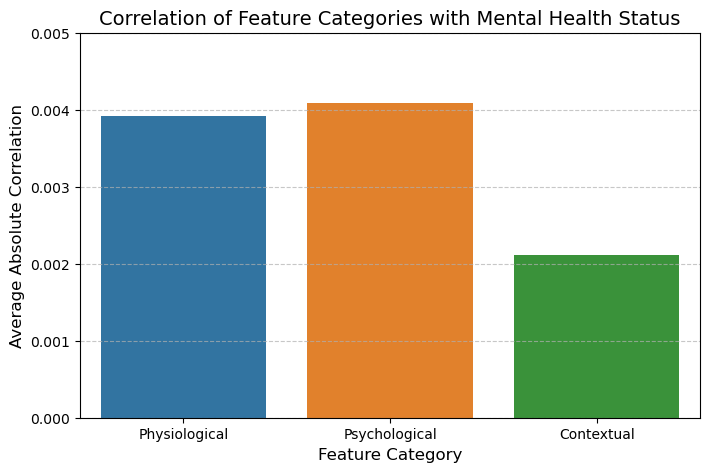

In [12]:
# Create DataFrame for visualization
corr_data = pd.DataFrame({
    "Category": ["Physiological", "Psychological", "Contextual"],
    "Correlation": [corr_phys, corr_psych, corr_context]
})

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x="Category", y="Correlation", hue="Category", data=corr_data, palette=["#1f77b4", "#ff7f0e", "#2ca02c"], legend=False)

# Customize plot
plt.title("Correlation of Feature Categories with Mental Health Status", fontsize=14)
plt.xlabel("Feature Category", fontsize=12)
plt.ylabel("Average Absolute Correlation", fontsize=12)
plt.ylim(0, 0.005)  # Correlation values range from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

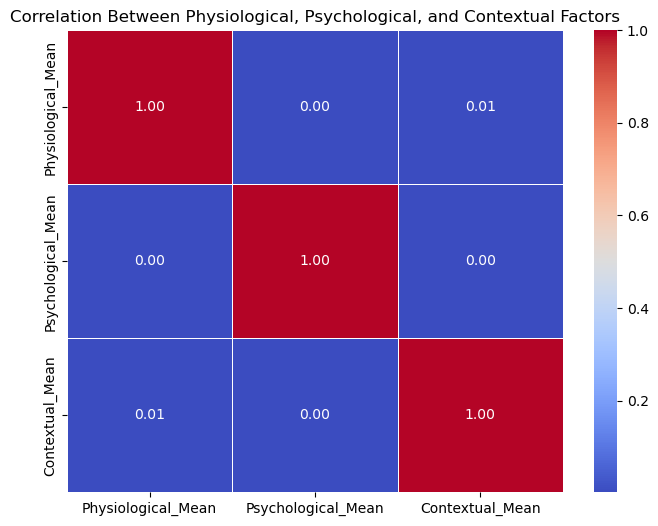

In [13]:
# Compute mean for each category
df["Physiological_Mean"] = df[phys_features].mean(axis=1)
df["Psychological_Mean"] = df[psych_features].mean(axis=1)
df["Contextual_Mean"] = df[context_features].mean(axis=1)

# Create a new DataFrame for correlation analysis
category_df = df[["Physiological_Mean", "Psychological_Mean", "Contextual_Mean"]]

# Compute correlation matrix
correlation_matrix = category_df.corr()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title and labels
plt.title("Correlation Between Physiological, Psychological, and Contextual Factors")
plt.show()

# Compute P-values

Use features from each categories with the strongest correlation to check its significance

In [14]:
stat, p_value = kstest(df["Activity_Levels"], "norm")
print(f"Kolmogorov-Smirnov Test Statistic: {stat}, P-value: {p_value}")

Kolmogorov-Smirnov Test Statistic: 0.5, P-value: 0.0


In [15]:
corr, p_value = spearmanr(df["Activity_Levels"], df["Mental_Health_Status"])
print(f"Spearman Correlation: {corr}, P-value: {p_value}")

Spearman Correlation: -0.0063936622531808145, P-value: 0.1426107922489292


In [16]:
stat, p_value = kstest(df["Resilience_Factors"], "norm")
print(f"Kolmogorov-Smirnov Test Statistic: {stat}, P-value: {p_value}")

Kolmogorov-Smirnov Test Statistic: 0.5, P-value: 0.0


In [17]:
corr, p_value = spearmanr(df["Resilience_Factors"], df["Mental_Health_Status"])
print(f"Spearman Correlation: {corr}, P-value: {p_value}")

Spearman Correlation: -0.008070390589553965, P-value: 0.06422117937510884


In [18]:
stat, p_value = kstest(df["Social_Interaction"], "norm")
print(f"Kolmogorov-Smirnov Test Statistic: {stat}, P-value: {p_value}")

Kolmogorov-Smirnov Test Statistic: 0.5, P-value: 0.0


In [19]:
corr, p_value = spearmanr(df["Social_Interaction"], df["Mental_Health_Status"])
print(f"Spearman Correlation: {corr}, P-value: {p_value}")

Spearman Correlation: 0.003617998244457782, P-value: 0.4067415919133248


All three features (Activity_Levels, Resilience_Factors, Social_Interaction) have p-value > 0.05. \
This suggests that none of the features have a statistically significant correlation with Mental_Health_Status and fail to reject the null hypothesis.

# Type I and Type II errors

In [20]:
# Set parameters
effect_size = 0.2  # Small effect
alpha = 0.05
power = 0.8

# Compute required sample size to detect the effect
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)

print(f"Required sample size per group: {int(sample_size)}")

Required sample size per group: 393


Each feature has 52585 samples which exceeds the required sample size per group of 393.\
There is a low chance of Type II error.

# Conclusion

Based on the statistical analysis, the high p-value indicates that we fail to reject the null hypothesis, suggesting that Activity Level, Resilience Factors, and Social Interaction do not show a significant correlation with Mental Health Status in this dataset.

However, before drawing definitive conclusions, I recommend assessing the validity and reliability of the dataset. Ensuring accurate data collection methods, appropriate measurement scales, and sufficient variability in the data could help refine future analyses and improve the reliability of these findings.